In [1]:
import numpy as np
import scipy as sp
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
def dilser(low=0.001, limit=100., dilfactor=2.):
    '''returns a numpy array dilution series from low to limit by dilfactor'''
    #replace this with a generator/iterator someday
    a = [low]
    while a[-1] <= limit:
        a.append(a[len(a)-1]*dilfactor)
    return np.array(a)

def k1mod(params,ligs,noise=None):
    '''
    theoretical model for single binding site
    
    returns tuple of ligand concentrations, saturation, params

    params is array of binding constants
    ligs is array of ligand concentrations
    noise is relative percent of gaussian noise (e.g., 0.0-1.) applied to data
    '''

    k1 = params[0]
    sat = (k1*ligs)/(1 + k1*ligs)

    if noise is None:
        return (ligs,sat)
    else:
        noised = np.random.normal(sat,noise*sat)
        return (ligs,noised,params)

def k2mod(params,ligs,noise=None):
    '''
    theoretical model for a two-site receptor
    
    returns tuple of ligand concentrations, saturation, params

    params is array of binding constants
    ligs is array of ligand concentrations
    noise is relative percent of gaussian noise (e.g., 0.0-1.) applied to data
    '''

    k1 = params[0]
    k2 = params[1]
    sat = (1/2)*((k1*ligs + 2*k1*k2*(ligs**2))/(1 + k1*ligs + k1*k2*(ligs**2)))

    if noise is None:
        return (ligs,sat)
    else:
        noised = np.random.normal(sat,noise*sat)
        return (ligs,noised,params)

def k2mod_fix(params,ligs,noise=None):
    '''
    returns tuple of ligand concentrations, saturation, params

    params is array of binding constants
    ligs is array of ligand concentrations
    noise is relative percent of gaussian noise (e.g., 0.0-1.) applied to data
    '''

    k1 = params[0]
    k2 = params[0]/4
    sat = (1/2)*((k1*ligs + 2*k1*k2*(ligs**2))/(1 + k1*ligs + k1*k2*(ligs**2)))

    if noise is None:
        return (ligs,sat)
    else:
        noised = np.random.normal(sat,noise*sat)
        return (ligs,noised,params)

def obj(guess,model,data):
    return model(guess,data[0])[1] - data[1]

def obj_wt(guess,model,data,wt):
    return (model(guess,data[0])[1] - data[1])/(wt*data[1])

def fit(data,model,guess):
        return sp.optimize.least_squares(obj,guess,args=(model,data),ftol=1e-14,gtol=1e-14,xtol=1e-14)
    
def fit_wt(data,model,guess,wt):
        return sp.optimize.least_squares(obj_wt,guess,args=(model,data,wt),ftol=1e-14,gtol=1e-14,xtol=1e-14)

def ftest(fit1,fit2):
    '''
    fit1 is fit from simpler model
    '''

    SS1 = np.sum(np.square(fit1.fun))
    SS2 = np.sum(np.square(fit2.fun))

    DF1 = fit1.fun.shape[0] - fit1.x.shape[0]
    DF2 = fit2.fun.shape[0] - fit2.x.shape[0]

    F = ((SS1-SS2)/(DF1-DF2))/(SS2/DF2)

    p = sp.stats.f.sf(F,(DF1-DF2),DF2)

    return (SS1,SS2,DF1,DF2,F,p)

In [3]:
ligs = dilser()

In [4]:
datsets_k1 = [k1mod(np.array([1.0]),ligs,0.05) for i in range(1000)]

In [5]:
fitsa = [fit(i,k2mod_fix,np.array([1.])) for i in datsets_k1]

In [6]:
np.mean([i.x[0] for i in fitsa])

2.0001033254587122

In [7]:
fitsb = [fit(i,k2mod,np.array([1.,1.])) for i in datsets_k1]

In [8]:
fitsb[1].x

array([ 1.68693575,  0.47013293])

In [9]:
ratios = np.array([i.x[0]/i.x[1] for i in fitsb])

In [10]:
ratios.shape

(1000,)

In [11]:
%matplotlib inline

(array([  52.,  192.,  277.,  242.,  132.,   53.,   38.,   11.,    1.,    2.]),
 array([ 1.68498117,  2.47843434,  3.27188751,  4.06534069,  4.85879386,
         5.65224703,  6.4457002 ,  7.23915337,  8.03260654,  8.82605972,
         9.61951289]),
 <a list of 10 Patch objects>)

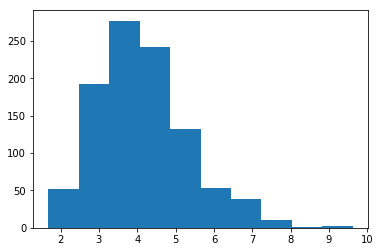

In [12]:
plt.hist(ratios)

In [13]:
np.log(4.)

1.3862943611198906

In [14]:
fitsc = [fit_wt(i,k2mod,np.array([1.,1.]),0.05) for i in datsets_k1]

In [15]:
ratiosb = np.array([i.x[0]/i.x[1] for i in fitsb])

In [16]:
ratiosc = np.array([i.x[0]/i.x[1] for i in fitsc])

(array([  17.,   72.,  168.,  249.,  218.,  146.,   73.,   30.,   20.,    7.]),
 array([ 2.85643789,  3.15442376,  3.45240962,  3.75039549,  4.04838136,
         4.34636722,  4.64435309,  4.94233895,  5.24032482,  5.53831069,
         5.83629655]),
 <a list of 10 Patch objects>)

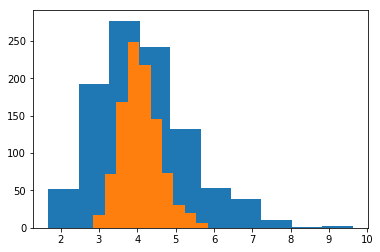

In [17]:
plt.hist(ratiosb)
plt.hist(ratiosc)

In [18]:
def lhood(guess,model,data):
    '''
    Gaussian likelihood function for simple binding models. Includes error as 'nuissance' parameter
    guess must contain additional parameter at the last index of the array --- this is the noise parameter
    '''
    params = guess[:-1]
    f = guess[-1] #noise
    invsig2 = 1.0/((f*data[1])**2)
    return -0.5*(np.sum((data[1] - model(params,data[0])[1])**2*invsig2 - np.log(invsig2)))

def lnpri(guess,bounds):
    assert len(bounds) == len(guess)
    if all([bounds[i][0] <= guess[i] <= bounds[i][1] for i in range(len(bounds))]) is True:
        return 0.0
    else:
        return -np.inf
    
def lnprob(guess,bounds,model,data):
    lp = lnpri(guess,bounds)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lhood(guess,model,data)

In [19]:
lhood(np.array([1.,1.,0.05]),k2mod,datsets_k1[0])

-287.91049380883726

In [20]:
nll = lambda *args: -lhood(*args)

In [21]:
nll(np.array([1.,1.,0.05]),k2mod,datsets_k1[0])

287.91049380883726

In [34]:
bnds = ((0.001,100.),(0.001,100.),(1e-3,0.1))

In [23]:
guess = np.array([1.,0.5,0.05])

In [24]:
sp.optimize.minimize(nll,guess,args=(k2mod,datsets_k1[0]),method='L-BFGS-B',bounds=bnds,options={'ftol':1e-14,'gtol':1e-14}).x 

array([ 1.96869705,  0.56636863,  0.06014113])

In [30]:
np.log(0.001),np.log(0.5)

(-6.9077552789821368, -0.69314718055994529)

In [35]:
def lhood2(guess,model,data):
    '''
    Gaussian likelihood function for simple binding models. Includes error as 'nuissance' parameter
    guess must contain additional parameter at the last index of the array --- this is the noise parameter
    '''
    params = guess[:-1]
    f = guess[-1] #noise
    invsig2 = 1.0/(data[1]**2 * np.exp(2*f))
    return -0.5*(np.sum(((model(params,data[0])[1] - data[1])**2 * invsig2 - np.log(invsig2))))

In [36]:
nll2 = lambda *args: -lhood2(*args)
bnds2 = ((0.01,10.),(0.01,10.),(-7.,-0.7))
guess2 = np.array([1.,0.5,-2.])

In [37]:
sp.optimize.minimize(nll2,guess2,args=(k2mod,datsets_k1[0]),method='L-BFGS-B',bounds=bnds2,options={'ftol':1e-14,'gtol':1e-14}).x 

array([ 1.96869705,  0.56636863, -2.81106122])

In [39]:
def lnprob2(guess,bounds,model,data):
    lp = lnpri(guess,bounds)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lhood2(guess,model,data)

In [40]:
np.exp(-2.81106)

0.060141208911654677

In [41]:
fitsb[0].x

array([ 1.94791773,  0.57391866])

In [42]:
fitsc[0].x

array([ 1.96869705,  0.56636864])

In [43]:
lnpri(guess,bnds)

0.0

In [44]:
lnprob(np.array([100.,100.,0.01]),bnds,k2mod,datsets_k1[0])

-75349210.591120318

In [45]:
import sys, copy, emcee, corner

In [47]:
ndim, nwalkers = 3, 100
pos = [np.random.normal(1.,0.05)*guess2 for i in range(nwalkers)]

In [48]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob2,args=(bnds2,k2mod,datsets_k1[0]))

In [49]:
sampler.run_mcmc(pos,1000);

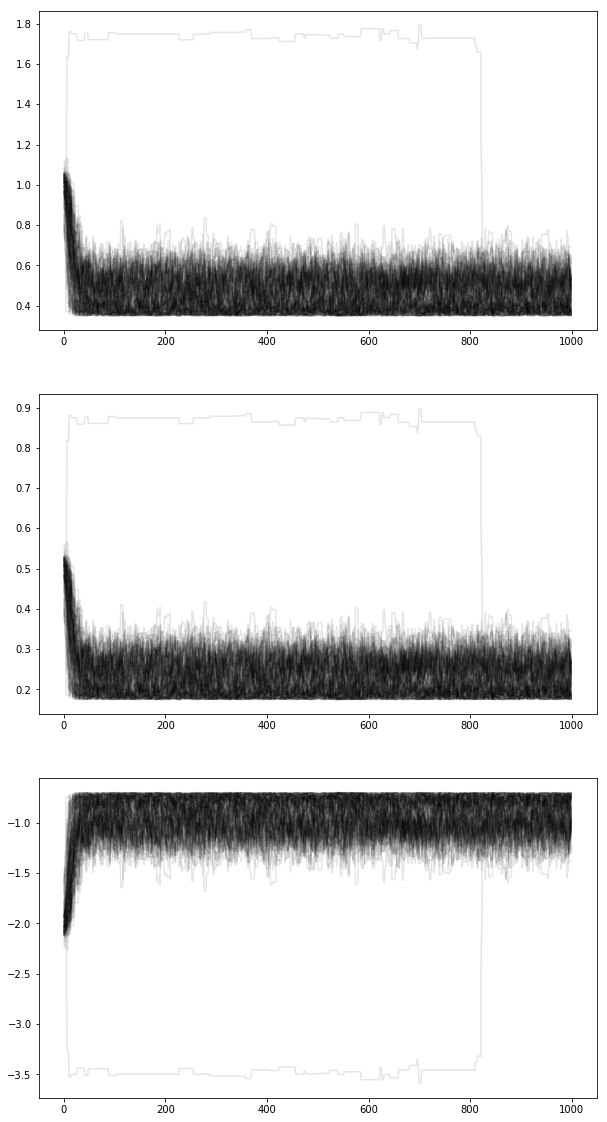

In [50]:
fig = plt.figure(figsize=(10,20))
for i in range(3):
    ax1 = fig.add_subplot(3,1,(i+1))
    ax1.plot(sampler.chain[:,:,i].T, '-', color='k', alpha=0.1);

In [51]:
samples = sampler.chain[:, 500:, :].reshape((-1, ndim))

In [52]:
samples[0]

array([ 0.44400447,  0.22200223, -0.88800893])

In [53]:
datsets_k1[0][2]

array([ 1.])

In [54]:
lnpri(np.array([.01,.01,.01]),bnds)

0.0

In [55]:
np.random.normal(1.,0.05)*guess

array([ 1.05809006,  0.52904503,  0.0529045 ])

In [56]:
bnds

((0.001, 100.0), (0.001, 100.0), (0.001, 0.1))

In [86]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(bnds,k2mod,datsets_k1[0]))

In [88]:
pos = [np.random.normal(1.,0.05)*guess for i in range(nwalkers)]

In [89]:
pos[0]

array([ 0.96675439,  0.48337719,  0.04833772])

In [90]:
sampler.run_mcmc(pos,1000)

(array([[ 1.85087414,  0.92543707,  0.08803537],
        [ 1.83506062,  0.91753031,  0.07529149],
        [ 1.89783623,  0.94891812,  0.08464907],
        [ 1.958503  ,  0.9792515 ,  0.09768984],
        [ 1.7920607 ,  0.89603035,  0.0839853 ],
        [ 1.76158698,  0.88079349,  0.07651505],
        [ 1.8388054 ,  0.9194027 ,  0.06525718],
        [ 1.8012618 ,  0.9006309 ,  0.06828791],
        [ 1.85339339,  0.9266967 ,  0.08605617],
        [ 1.90445682,  0.95222841,  0.08324811],
        [ 1.83911314,  0.91955657,  0.0744919 ],
        [ 1.85639153,  0.92819577,  0.07462284],
        [ 1.80391826,  0.90195913,  0.09763663],
        [ 1.88166413,  0.94083207,  0.09225316],
        [ 1.71684568,  0.85842284,  0.0769536 ],
        [ 1.74539005,  0.87269502,  0.09578732],
        [ 1.83362849,  0.91681425,  0.08830867],
        [ 1.80627264,  0.90313632,  0.08552032],
        [ 1.72806528,  0.86403264,  0.09729805],
        [ 1.79174671,  0.89587335,  0.08166146],
        [ 1.93477025

In [91]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

(array([    36.,    268.,   1346.,   3561.,   6737.,   9169.,  12133.,
         18737.,  21318.,  21695.]),
 array([ 0.05085499,  0.05576931,  0.06068363,  0.06559796,  0.07051228,
         0.0754266 ,  0.08034093,  0.08525525,  0.09016957,  0.0950839 ,
         0.09999822]),
 <a list of 10 Patch objects>)

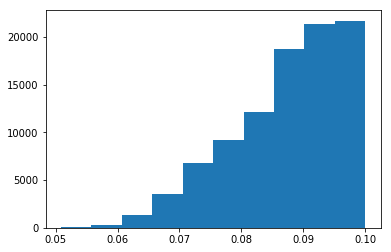

In [95]:
plt.hist(samples[:,2])

In [99]:
guess[-1]

0.050000000000000003